In [15]:
import numpy as np
###list of data files
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time
import math
from itertools import groupby
from operator import itemgetter
import more_itertools as mit
import time
from numpy import array
from numpy.random import rand
import datetime

In [16]:
def check_outlier(x):
    if x > 1.5 or x < -1.5:
        return "True"
    else:
        return "False"

In [17]:
def transfer_to_list_of_pd(clusters_list):
    clusters_data_list = []
    for i in clusters_list:
        temp_data = pd.DataFrame(i, columns =['SecurityID', 'Sector', 'Industry','Sub_Industry','Seniority','Issuedby','Country','Rating','AmountIssued','Coupon','IssueDate','MaturityDate'])
        clusters_data_list.append(temp_data)
    return clusters_data_list

In [18]:
def assign_rating(x):
    x = float(x)
    if x < 0:
        return 'NR'
    elif x >0 and x<=0.5:
        return 'D'
    elif x > 0.5 and x<=1.5:
        return 'C'
    elif x > 1.5 and x<=2.5:
        return 'CC-'
    elif x > 2.5 and x<=3.5:
        return 'CC'
    elif x >3.5 and x<=4.5:
        return 'CC+'
    elif x >4.5 and x <=5.5:
        return 'CCC-'
    elif x >5.5 and x <=6.5:
        return 'CCC'
    elif x >6.5 and x<=7.5:
        return 'CCC+'
    elif x >7.5 and x <= 8.5:
        return 'B-'
    elif x>8.5 and x <=9.5:
        return 'B'
    elif x> 9.5 and x <= 10.5:
        return 'B+'
    elif x >10.5 and x<=11.5:
        return 'BB-'
    elif x > 11.5 and x<=12.5:
        return 'BB'
    elif x >12.5 and x<=13.5:
        return 'BB+'
    elif x>13.5 and x <=14.5:
        return 'BBB-'
    elif x>14.5 and x<=15.5:
        return 'BBB'
    elif x>15.5 and x<=16.5:
        return 'BBB+'
    elif x>16.5 and x<=17.5:
        return 'A-'
    elif x > 17.5 and x<=18.5:
        return 'A'
    elif x >18.5 and x<=19.5:
        return 'A+'
    elif x>19.5 and x<=20.5:
        return 'AA-'
    elif x >20.5 and x<=21.5:
        return 'AA'
    elif x>21.5 and x<=22.5:
        return 'AA+'
    else:
        return 'AAA'

In [19]:
def process_rating_data(data):
    #data = data[data['KeyDate']<=end_date]
    rating = data.groupby('SecurityID',as_index=False).mean()
    rating['RatingSP'] = rating['RatingSP'].apply(lambda x:assign_rating(x))
    return rating

In [20]:
def grab_clusters(clusters,bond_spread_list,security_data,rating_data):
    temp_list = []
    for cluster in clusters:
        temp_list2 = []
        for bond_index in cluster:
            bond_id = bond_spread_list[bond_index][1]
            bond_Sector = security_data[security_data['SecurityID']==bond_id].SecuritySector.iloc[0]
            bond_Industry = security_data[security_data['SecurityID'] == bond_id].SecurityIndustry.iloc[0]
            bond_sub_Industry = security_data[security_data['SecurityID'] == bond_id].SecuritySubIndustry.iloc[0]
            bond_Seniority = security_data[security_data['SecurityID'] == bond_id].Seniority.iloc[0]
            bond_Issuer =security_data[security_data['SecurityID'] == bond_id].Issuer.iloc[0]
            bond_countryrisk =security_data[security_data['SecurityID'] == bond_id].CountryRisk.iloc[0]
            bond_amountIssued =security_data[security_data['SecurityID'] == bond_id].AmountIssued.iloc[0]
            bond_coupon =security_data[security_data['SecurityID'] == bond_id].Coupon.iloc[0]
            bond_MaturityDate =security_data[security_data['SecurityID'] == bond_id].MaturityDate.iloc[0]
            bond_issuedate =security_data[security_data['SecurityID'] == bond_id].IssueDate.iloc[0][:4]
            try:
                bond_rating=rating_data[rating_data['SecurityID'] == bond_id].RatingSP.iloc[0]
            except:
                bond_rating = 'Not Founded'
            temp_tuple = (bond_id,bond_Sector,bond_Industry,bond_sub_Industry,bond_Seniority,bond_Issuer,bond_countryrisk,bond_rating,bond_amountIssued,bond_coupon,bond_issuedate,bond_MaturityDate)
            temp_list2.append(temp_tuple)
        temp_list.append(temp_list2)
    return temp_list

In [21]:
def merge_left_right(data1,data2):
    temp_data = data1.append(data2)
    return temp_data

def merg_sort(list_data):
    list_length = len(list_data)
    if list_length == 1:
        output = list_data[0][2]
        return output
    else:
        mid_point = math.floor(list_length/2)
        #print(len(list_data[:mid_point]))
        left = list_data[mid_point:]
        right = list_data[:mid_point]
        return merge_left_right(merg_sort(left), merg_sort(right))

In [22]:
def sliding_windows(data,period_of_time,start_date):
    #transfer start_date to datetime()
    time_list = start_date.split('-')
    year = int(time_list[0])
    month = int(time_list[1])
    date = int(time_list[2])
    start_datetime = datetime.datetime(year, month, date)
    data['KeyDate'] = pd.to_datetime(data['KeyDate'])
    data['MaturityDate'] = pd.to_datetime(data['MaturityDate'])
    data['IssueDate'] = pd.to_datetime(data['IssueDate'])
    ###find the end date:
    end_datetime = start_datetime + datetime.timedelta(days=period_of_time)
    end_date = str(end_datetime.date())
    #####select data before the end_date
    data = data[data['KeyDate'] <= end_date]
    data = data[data['IssueDate'] <= start_datetime]
    data = data[data['MaturityDate'] >= end_date]
    return data

In [23]:
def apply_fill(data_list,index):
    for i in data_list:
        try:
            fill_the_GSpeard(i)
        except:
            index.append(i)
    return index,data_list

In [24]:
def merge_data(lists,initial_data):
    data = initial_data
    for file in lists:
        #path = 'C:\\Users\\y437l\\OneDrive\\MMAI\\Capstone\\Data\\{}'.format(file)
        path = '/Users/yangli/OneDrive/MMAI/Capstone/Data/{}'.format(file)
        temp_data = pd.read_csv(path)
        print(len(temp_data))
        data = data.append(temp_data)
        print(len(data))
    return data

In [25]:
start_time = time.time()
#security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data = security_data[['SecurityID','Currency','IssueDate','MaturityDate']]
### merge spread data togther
sc = MinMaxScaler()
#data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/1.csv")
data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/1.csv")
file_lists = ['14426.csv','24001.csv','36128.csv','48087.csv','55086.csv']
final_data = merge_data(file_lists,data)
#final_data = data
###left join the currency data into the spread data
final_data = final_data.merge(security_data, on=['SecurityID'], how='left')
final_data.dropna(subset=["ZSpread"],inplace=True)
###select currency as USD
final_data_1 = final_data[final_data.Currency == 'USD']
final_data = final_data_1.groupby('SecurityID')
###create a list of bond with data
bonds_list = [final_data.get_group(x) for x in final_data.groups]

1054948
2103331
961878
3065209
1074473
4139682
869630
5009312
584171
5593483


In [26]:
final_data2 = merge_data(file_lists,data)

1054948
2103331
961878
3065209
1074473
4139682
869630
5009312
584171
5593483


In [27]:
final_data2[(final_data2.SecurityID == 39321)&(final_data2.GSpread < 0)]

,SecurityID,KeyDate,Price,YieldWorst,ModifiedDuration_Plain,WorkoutDate,AmtOutstanding,GSpread,OAS_Spread,ZSpread,AswUsd
106678,39321,2019-01-30 00:00:00,100.193,1.137320,1.85537,2021-02-15 00:00:00,300000000.0,-137.110000,-141.688,-179.772,-151.431
106679,39321,2019-01-31 00:00:00,100.320,-4.181400,1.84828,2021-02-15 00:00:00,300000000.0,-663.510000,-682.297,-721.877,-707.487
106680,39321,2019-02-01 00:00:00,100.266,-3.306180,1.84538,2021-02-15 00:00:00,300000000.0,-580.940000,-592.094,-631.384,-614.874
106681,39321,2019-02-04 00:00:00,100.142,0.432267,1.84209,2021-02-15 00:00:00,300000000.0,-210.270000,-210.429,-255.966,-224.229
106682,39321,2019-02-05 00:00:00,100.122,0.639026,1.83937,2021-02-15 00:00:00,300000000.0,-188.130000,-187.995,-232.031,-202.849
...,...,...,...,...,...,...,...,...,...,...,...
106910,39321,2020-01-03 00:00:00,100.083,-22.040200,1.04246,2021-02-15 00:00:00,151831000.0,-2354.092142,-2534.880,-2445.570,-2568.640
106911,39321,2020-01-06 00:00:00,100.098,-26.437700,1.03992,2021-02-15 00:00:00,151831000.0,-2796.075065,-3041.640,-2902.230,-3080.170
106912,39321,2020-01-07 00:00:00,100.125,-34.541200,1.03744,2021-02-15 00:00:00,151831000.0,-3604.575038,-4011.470,-3713.860,-4062.220
106913,39321,2020-01-08 00:00:00,100.094,-25.304900,1.03468,2021-02-15 00:00:00,151831000.0,-2683.392015,-673.805,-3194.290,-1097.140


In [28]:
#security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data[security_data.SecurityID == 39321]

,SecurityID,OfficialName,SecurityType,SecuritySubType,SecurityBBGType,SecurityBBGYellowKey,Series,SecuritySector,SecurityIndustry,SecuritySubIndustry,...,Seniority,PaymentRank,IsBailIn,QuoteSize,AmountIssued,MinIncrement,MinPiece,BBGDescription,CallSchedule,AdditionalData
15287,39321,CACC 6.125 02/15/21,Bond,Bond,GLOBAL,Corp,NaN,Financials,Consumer Finance,Finance-Auto Loans,...,Sr Unsecured,Sr Unsecured,N,100,300000000.0,1000.0,2000.0,NaN,"[[2017-02-15T00:00:00""",103.063]


In [29]:
def fill_the_GSpeard(data):
    ##calucate the spread between gspread and z spread if the gspread is not 0.
    data['Spread_G_Z'] = data.GSpread - data.ZSpread
    ###find the nan data's index in the data:
    index_with_indicator = data.GSpread.isna()
    index_with_indicator = index_with_indicator.tolist()
    index_list = []
    for indx in range(0,len(index_with_indicator)):
        if index_with_indicator[indx] == True:
            index_list.append(indx)
    #print(index_list)
    ##find concustive missing value:
    ##example:[(22, 39), 303, (326, 343), 607]
    star_end_dates = find_ranges(index_list)
    missing_date_dict={}
    for periods in star_end_dates:
        if type(periods) !=tuple:
            missing_date_dict[str(periods)] = spread_slope(data,periods)
            value = data.Spread_G_Z.iloc[periods-1]+missing_date_dict[str(periods)][3]
            print(value)
            data.GSpread.iloc[periods] = data.ZSpread.iloc[periods]+value
            print(data.GSpread.iloc[periods])
        else:
            missing_date_dict['{}-{}'.format(periods[0],periods[1])] = spread_slope(data, periods)
            star = missing_date_dict['{}-{}'.format(periods[0],periods[1])][0]
            end = missing_date_dict['{}-{}'.format(periods[0],periods[1])][1]
            slope = missing_date_dict['{}-{}'.format(periods[0],periods[1])][3]
            for days in range(star+1,end):
                value = data.Spread_G_Z.iloc[star] + (days-star)*slope
                data.GSpread.iloc[days] = data.ZSpread.iloc[days]+value
    print(missing_date_dict)
    #if missing_date_dict['{}-{}'.format(periods[0],periods[1])][3] >=1:
        #print(missing_date_dict)
        #print("Warning {}".format(data.SecurityID.iloc[0]))
    return data

In [30]:
def find_ranges(iterable):
    """Yield range of consecutive numbers."""
    for group in mit.consecutive_groups(iterable):
        group = list(group)
        if len(group) == 1:
            yield group[0]
        else:
            yield group[0], group[-1]

In [31]:
def spread_slope(data,input):
    if type(input) != tuple:
        star = input-1
        end = input+1
    else:
        star = input[0] - 1
        end = input[1] + 1
    if end == len(data):
        slope = data.Spread_G_Z.iloc[star]
        end = 'None'
        gap = 1
    else:
        print(input)
        star_point = data.Spread_G_Z.iloc[star]
        print(star_point)
        end_point = data.Spread_G_Z.iloc[end]
        print(end_point)
        gap = (end-star)
        print(gap)
        slope = (end_point - star_point) / gap
        print(slope)
    return (star, end, gap,slope)

In [32]:
def select_data(num,listoftuble):
    temp_list = []
    for i in listoftuble:
        if i[0] == num:
            temp_list.append(i)
    return temp_list

## Select the data with only spread percentage change.
def select_spread_data(listoftuble):
    temp_list = []
    for i in listoftuble:
        temp_list.append(i[2])
    return temp_list

In [33]:
problemtic_data_index =[]
problem_data_index,bonds_list = apply_fill(bonds_list,problemtic_data_index)
print("--- %s seconds ---" % (time.time() - start_time),'Next Step:Percentage Changed')

0001
-1.9551934999999787
452.98280650000004
78
-1.6455179999999245
-3.3275160000000596
2
-0.8409990000000676
-2.486516999999992
459.559483
{'70': (69, 71, 2, -1.622106500000001), '78': (77, 79, 2, -0.8409990000000676)}
{}
{}
35
-6.992733000000044
-9.745722999999998
2
-1.3764949999999772
-8.369228000000021
278.55177199999997
{'35': (34, 36, 2, -1.3764949999999772)}
58
-11.362067999999994
-14.605354000000005
2
-1.621643000000006
-12.983711
194.527289
{'58': (57, 59, 2, -1.621643000000006)}
58
-6.080476000000004
-9.531576000000001
2
-1.7255499999999984
-7.806026000000003
202.462974
66
-6.853035000000034
-8.256179000000003
2
-0.7015719999999845
-7.5546070000000185
212.96239299999996
{'58': (57, 59, 2, -1.7255499999999984), '66': (65, 67, 2, -0.7015719999999845)}
51
-12.987908000000004
-13.714681000000013
2
-0.3633865000000043
-13.351294500000009
205.3507055
{'51': (50, 52, 2, -0.3633865000000043)}
71
-5.563229999999976
-8.028028999999947
2
-1.2323994999999854
-6.795629499999961
508.3113705

In [34]:
bond_spread_list = []
for bond in bonds_list:
    try:
        bond['G_change']=bond.GSpread.pct_change()
        bond.dropna(subset=['G_change'],inplace = True)
        bond['G_std']=bond['G_change'].rolling(7).std()
        bond.dropna(subset=['G_std'],inplace = True)
        bond['outlier'] = bond.G_change.apply(check_outlier)
        bond = sliding_windows(bond, 60, '2019-01-10')
        if "True" not in bond['outlier'].values:
            bond_spread_list.append((len(bond.GSpread.values),bond.SecurityID.iloc[0],bond))
    except:
        pass

In [35]:
#bond_spread_list[0][2]['G_std'] = bond_spread_list[0][2]['G_change'].rolling(10).std()
#bond = sliding_windows(bond_spread_list[0][2], 90, '2019-01-08')

In [36]:
len(bond_spread_list)

14079

In [37]:
bond_spread_list[0][2].tail()

,SecurityID,KeyDate,Price,YieldWorst,ModifiedDuration_Plain,WorkoutDate,AmtOutstanding,GSpread,OAS_Spread,ZSpread,AswUsd,Currency,IssueDate,MaturityDate,Spread_G_Z,G_change,G_std,outlier
43,64,2019-03-05,96.5689,5.56905,6.09383,08/15/2026 0:00,1.697266e+09,292.25,237.116,291.805,279.788,USD,2016-08-03,2026-08-15,0.445,-0.003240,0.015033,False
44,64,2019-03-06,96.4847,5.58348,6.09026,08/15/2026 0:00,1.697266e+09,296.92,242.100,295.790,283.445,USD,2016-08-03,2026-08-15,1.130,0.015979,0.016908,False
45,64,2019-03-07,96.1600,5.63922,6.07866,08/15/2026 0:00,1.697266e+09,308.07,254.541,306.732,293.425,USD,2016-08-03,2026-08-15,1.338,0.037552,0.022707,False
46,64,2019-03-08,95.7555,5.70859,6.07115,08/15/2026 0:00,1.697266e+09,316.78,263.771,314.902,300.496,USD,2016-08-03,2026-08-15,1.878,0.028273,0.024609,False
47,64,2019-03-11,95.8750,5.68830,6.07008,08/15/2026 0:00,1.697266e+09,313.78,259.787,311.232,297.233,USD,2016-08-03,2026-08-15,2.548,-0.009470,0.024310,False


In [38]:
sc = MinMaxScaler()

In [39]:
new_data = merg_sort(bond_spread_list)

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
def get_resid(x):
    try:
        result = seasonal_decompose(x,model='additive', period=2)
        yt = result.resid[1:-1]
        return yt
    except:
        print(x)

In [41]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(get_resid(bond_spread_list[0][2].GSpread.pct_change().dropna()),lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,18.337898,0.000018


In [42]:
import entropy

In [43]:
import statsmodels.api as sm
from statistics import stdev 
import nolds
from scipy.stats import norm, kurtosis
from scipy.stats import skew 
kurtosis_dict = {}
kurtosis_dict1 = {}
skewness_dict = {}
skewness_dict1 = {}
mean_dict = {}
mean_dict1 = {}
Chaos_dict = {}
Chaos_dict1 = {}
serial_dict = {}
serial_dict1 = {}
std_dict = {}
std_dict1 = {}
max_dict = {}
max_dict1 = {}
min_dict = {}
min_dict1 = {}
std_mean = {}
## 95% value
cirtical1_dict = {}
cirtical1_dict1 = {}
## 75% value
cirtical2_dict = {}
cirtical2_dict1 = {}
## median value
cirtical3_dict = {}
cirtical3_dict1 = {}
## 25% value
cirtical4_dict = {}
cirtical4_dict1 = {}
for i in bond_spread_list:
    try:
        security = i[1]
        train = i[2].GSpread.pct_change().dropna()
        de_train = get_resid(train)
        #train
        a = kurtosis(train)
        #detrend
        a1 = kurtosis(de_train)
        #train
        b = skew(train)
        #detrend
        b1 = skew(de_train)
        #train
        c = np.mean(train)
        #detrend
        c1 = np.mean(de_train)
        #trend
        h = nolds.dfa(train)
        #detrend
        h1 = nolds.dfa(de_train)
        #train
        q = sm.stats.acorr_ljungbox(train, lags=[1], return_df=True)['lb_stat'].iloc[0]
        #detrend
        q1 = sm.stats.acorr_ljungbox(de_train, lags=[1], return_df=True)['lb_stat'].iloc[0]
        #standard deviation
        std = stdev(train)
        #detrend
        std1 = stdev(de_train)
        #trend max
        max1 = np.max(train)
        #detrend max
        dmax = np.max(de_train)
        #trend max
        min1 = np.min(train)
        #detrend max
        dmin = np.min(de_train)
        #trend 95%
        p1 = np.percentile(train, 95)
        #dtrend 95%
        dp1 = np.percentile(de_train, 95)
        #trend 75%
        p2 = np.percentile(train, 75)
        #dtrend 75%
        dp2 = np.percentile(de_train, 75)
        #trend median
        p3 = np.median(train)
        #detrend median
        dp3 = np.median(de_train)
        #trend 25%
        p4 = np.percentile(train, 25)
        #dtrend 25%
        dp4 = np.percentile(de_train, 25)
        #mean of std
        mean_std = np.mean(i[2]['G_std'])
        ##append to the dict
        kurtosis_dict[security] = a
        kurtosis_dict1[security] = a1
        skewness_dict[security] = b
        skewness_dict1[security] = b1
        mean_dict[security] = c
        mean_dict1[security] = c1
        Chaos_dict[security] = h
        Chaos_dict1[security] = h1
        serial_dict[security] = q
        serial_dict1[security] = q1
        std_dict[security] = std
        std_dict1[security]=std1
        max_dict[security] = max1
        max_dict1[security]=dmax
        min_dict[security] = min1
        min_dict1[security]=dmin
        cirtical1_dict[security] = p1
        cirtical1_dict1[security]=dp1
        cirtical2_dict[security] = p2
        cirtical2_dict1[security]=dp2
        cirtical3_dict[security] = p3
        cirtical3_dict1[security]=dp3
        cirtical4_dict[security] = p4
        cirtical4_dict1[security]=dp4
        std_mean[security] = mean_std
    except:
        pass

823329   -0.006036
Name: GSpread, dtype: float64
2516816    0.009125
2516817   -0.026881
Name: GSpread, dtype: float64
3316382   -0.013275
Name: GSpread, dtype: float64
Series([], Name: GSpread, dtype: float64)
Series([], Name: GSpread, dtype: float64)
5355971   -0.002453
Name: GSpread, dtype: float64


In [44]:
std_mean_data = pd.DataFrame(std_mean.items(),columns = ['SecurityID','std_mean'])
std_mean_data.head()

,SecurityID,std_mean
0,64,0.026754
1,72,0.019919
2,78,0.023251
3,82,0.013294
4,83,0.037264


In [45]:
max_data = pd.DataFrame(max_dict.items(),columns = ['SecurityID','max'])
max_data1 = pd.DataFrame(max_dict1.items(),columns = ['SecurityID','dmax'])
max_data1.head()

,SecurityID,dmax
0,64,0.026967
1,72,0.040848
2,78,0.034825
3,82,0.016470
4,83,0.056596


In [46]:
min_data = pd.DataFrame(min_dict.items(),columns = ['SecurityID','min'])
min_data1 = pd.DataFrame(min_dict1.items(),columns = ['SecurityID','dmin'])
min_data1.head()

,SecurityID,dmin
0,64,-0.029406
1,72,-0.032045
2,78,-0.033676
3,82,-0.018586
4,83,-0.072379


In [47]:
cirtical1_data = pd.DataFrame(cirtical1_dict.items(),columns = ['SecurityID','95%'])
cirtical1_data1 = pd.DataFrame(cirtical1_dict1.items(),columns = ['SecurityID','d95%'])
cirtical1_data1.head()

,SecurityID,d95%
0,64,0.021959
1,72,0.021565
2,78,0.018931
3,82,0.009050
4,83,0.038266


In [48]:
cirtical2_data = pd.DataFrame(cirtical2_dict.items(),columns = ['SecurityID','75%'])
cirtical2_data1 = pd.DataFrame(cirtical2_dict1.items(),columns = ['SecurityID','d75%'])
cirtical2_data1.head()

,SecurityID,d75%
0,64,0.010519
1,72,0.009933
2,78,0.012348
3,82,0.005205
4,83,0.015233


In [49]:
cirtical3_data = pd.DataFrame(cirtical3_dict.items(),columns = ['SecurityID','median'])
cirtical3_data1 = pd.DataFrame(cirtical3_dict1.items(),columns = ['SecurityID','dmedian'])
cirtical3_data1.head()

,SecurityID,dmedian
0,64,-0.000607
1,72,-0.001700
2,78,0.000121
3,82,0.000425
4,83,-0.004368


In [50]:
cirtical4_data = pd.DataFrame(cirtical4_dict.items(),columns = ['SecurityID','25%'])
cirtical4_data1 = pd.DataFrame(cirtical4_dict1.items(),columns = ['SecurityID','d25%'])
cirtical4_data1.head()

,SecurityID,d25%
0,64,-0.007166
1,72,-0.005205
2,78,-0.011700
3,82,-0.004471
4,83,-0.016274


In [51]:
mean_data = pd.DataFrame(mean_dict.items(),columns = ['SecurityID','mean'])
mean_data1 = pd.DataFrame(mean_dict1.items(),columns = ['SecurityID','dmean'])
mean_data1.head()

,SecurityID,dmean
0,64,0.000387
1,72,0.000652
2,78,-0.000548
3,82,0.000245
4,83,0.000200


In [52]:
std_data = pd.DataFrame(mean_dict.items(),columns = ['SecurityID','std'])
std_data1 = pd.DataFrame(mean_dict1.items(),columns = ['SecurityID','dstd'])
std_data1.head()

,SecurityID,dstd
0,64,0.000387
1,72,0.000652
2,78,-0.000548
3,82,0.000245
4,83,0.000200


In [53]:
Chaos_data = pd.DataFrame(mean_dict.items(),columns = ['SecurityID','chaos'])
Chaos_data1 = pd.DataFrame(mean_dict1.items(),columns = ['SecurityID','dchaos'])
Chaos_data1.head()

,SecurityID,dchaos
0,64,0.000387
1,72,0.000652
2,78,-0.000548
3,82,0.000245
4,83,0.000200


In [54]:
kurtosis_data = pd.DataFrame(kurtosis_dict.items(),columns = ['SecurityID','kurtosis'])
kurtosis_data1 = pd.DataFrame(kurtosis_dict1.items(),columns = ['SecurityID','dkurtosis'])
kurtosis_data1.head()

,SecurityID,dkurtosis
0,64,-0.463012
1,72,0.699707
2,78,-0.601921
3,82,0.189991
4,83,0.437651


In [55]:
skewness_data = pd.DataFrame(skewness_dict.items(),columns = ['SecurityID','skewness'])
skewness_data1 = pd.DataFrame(skewness_dict1.items(),columns = ['SecurityID','dskewness'])
skewness_data1.head()

,SecurityID,dskewness
0,64,-0.170856
1,72,0.165214
2,78,-0.084087
3,82,-0.312468
4,83,-0.109378


In [56]:
serial_data = pd.DataFrame(serial_dict.items(),columns = ['SecurityID','serial'])
serial_data1 = pd.DataFrame(serial_dict1.items(),columns = ['SecurityID','dserial'])
serial_data1.head()

,SecurityID,dserial
0,64,18.337898
1,72,22.009585
2,78,17.437164
3,82,12.708575
4,83,15.752953


The (discrete-time) Fourier transform

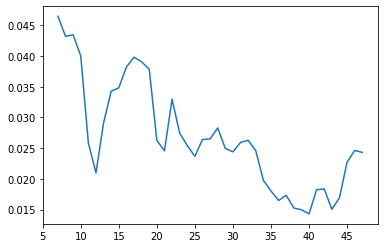

41

In [57]:
import matplotlib.pyplot as plt
plt.plot(bond_spread_list[0][2]['G_std'].dropna())
#plt.plot(bond_spread_list[0][2].GSpread.values)  
plt.show()
len(bond_spread_list[0][2].GSpread.values)

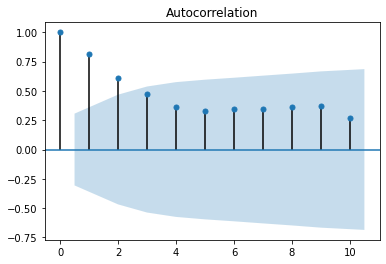

In [58]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress
import statistics 
plot_acf(bond_spread_list[0][2]['G_std'].dropna(), lags=10)
plt.show()

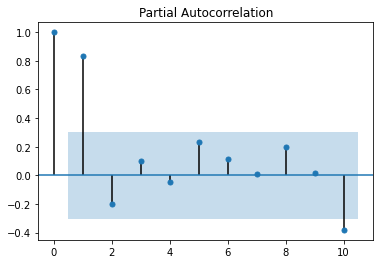

In [59]:
plot_pacf(bond_spread_list[0][2]['G_std'].dropna(), lags=10)
plt.show()

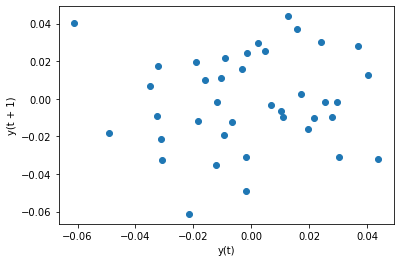

In [60]:
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
series = np.log(1+bond_spread_list[0][2].GSpread.pct_change().dropna())
lag_plot(series)
pyplot.show()

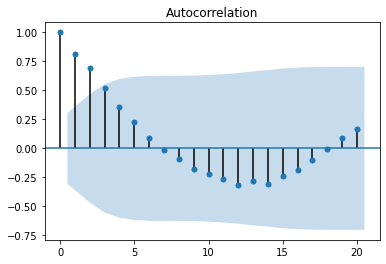

In [61]:
plot_acf(bond_spread_list[1][2].GSpread.values, lags=20)
plt.show()

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import statistics 

from scipy import stats
def get_trend_seasonal(x):
    try:
        train = x[2].GSpread.pct_change().dropna().to_numpy()
        sc = MinMaxScaler(feature_range = (0, 1))
        train = sc.fit_transform(train.reshape(-1,1))
        train = pd.Series(train.reshape(1,-1)[0])+0.0000001
        xt, _ = stats.boxcox(train)
        result = seasonal_decompose(xt,model='additive', freq=2)
        xt = result.resid + result.seasonal
        zt = result.resid + result.trend
        yt = result.resid
        yt[1:-1]
        m_seasonal = 1- np.var(yt[1:-1])/np.var(xt[1:-1])
        m_trend = 1- np.var(yt[1:-1])/np.var(zt[1:-1])
        return m_trend,m_seasonal
    except:
        print(x)

In [63]:
m_trend,m_seasonal = get_trend_seasonal(bond_spread_list[0])

In [64]:
m_trend

0.6786915781516523

In [65]:
trend_seasonal = pd.DataFrame(columns=['SecurityID', 'm_trend','m_seasonal'])

In [66]:
for i in bond_spread_list:
    try:
        security = i[1]
        m_trend,m_seasonal = get_trend_seasonal(i)
        temp_dict= {'SecurityID':security,'m_trend':m_trend,'m_seasonal':m_seasonal}
        temp_df = pd.DataFrame([temp_dict])
        trend_seasonal = trend_seasonal.append(temp_df)
    except:
        pass

(2, 11815,         SecurityID    KeyDate    Price  YieldWorst  ModifiedDuration_Plain  \
823328       11815 2019-03-08  96.5000     10.1986                 2.60286   
823329       11815 2019-03-11  96.5833     10.1674                 2.60098   

            WorkoutDate  AmtOutstanding  GSpread  OAS_Spread  ZSpread  \
823328  05/01/2022 0:00     350000000.0   776.95     709.764  767.476   
823329  05/01/2022 0:00     350000000.0   772.26     704.835  762.508   

         AswUsd Currency  IssueDate MaturityDate  Spread_G_Z  G_change  \
823328  737.485      USD 2017-05-02   2022-05-01       9.474  0.001521   
823329  733.111      USD 2017-05-02   2022-05-01       9.752 -0.006036   

           G_std outlier  
823328  0.004826   False  
823329  0.005022   False  )
(3, 32527,          SecurityID    KeyDate    Price  YieldWorst  ModifiedDuration_Plain  \
2516815       32527 2019-03-07  99.5813     7.08655                 4.80249   
2516816       32527 2019-03-08  99.4464     7.11472         

In [67]:
trend_seasonal

,SecurityID,m_trend,m_seasonal
0,64,0.678692,0.128382
0,72,0.563362,0.067850
0,78,0.493882,0.083049
0,82,0.660723,0.132500
0,83,0.572732,0.047826
...,...,...,...
0,64585,0.609149,0.260466
0,64586,0.530076,0.154109
0,64587,0.774662,0.082405
0,64588,0.518721,0.166197


In [68]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [69]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
def get_linear_parameter(x):
    train = x[2].GSpread.pct_change().dropna().to_numpy()
    result = seasonal_decompose(train,model='additive', freq=2)
    X = np.array(range(1, len(result.trend)-1)).reshape(-1, 1)
    y = result.trend[1:-1]
    reg = LinearRegression().fit(X, y)
    y_fit = reg.predict(X)
    coef = reg.coef_[0]
    intercept = reg.intercept_
    return coef,intercept

In [70]:
trend_seasonal_raw = pd.DataFrame(columns=['SecurityID', 'coef','intercept'])

In [71]:
for i in bond_spread_list:
    try:
        security = i[1]
        coef,intercept = get_linear_parameter(i)
        temp_dict= {'SecurityID':security,'coef':coef,'intercept':intercept}
        temp_df = pd.DataFrame([temp_dict])
        trend_seasonal_raw = trend_seasonal_raw.append(temp_df)
    except:
        pass

In [72]:
trend_seasonal_raw

,SecurityID,coef,intercept
0,64,0.000207,-0.005127
0,72,0.000189,-0.009471
0,78,0.000207,-0.014235
0,82,0.000137,-0.003844
0,83,0.000516,-0.018162
...,...,...,...
0,64585,0.000674,-0.012587
0,64586,-0.000486,0.004566
0,64587,0.000666,-0.015417
0,64588,0.000849,-0.006644


10

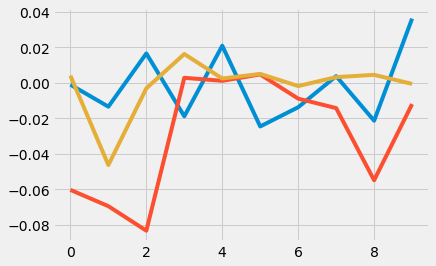

In [73]:
#Discrete Wavelet Transform
import pywt
coeffs = pywt.wavedec(bond_spread_list[0][2].GSpread.pct_change().dropna(), 'db1', level=2)
coeffs1 = pywt.wavedec(bond_spread_list[200][2].GSpread.pct_change().dropna(), 'db1', level=2)
coeffs2 = pywt.wavedec(bond_spread_list[300][2].GSpread.pct_change().dropna(), 'db1', level=2)
coeffs2 = pywt.wavedec(bond_spread_list[1000][2].GSpread.pct_change().dropna(), 'db1', level=2)
plt.plot(coeffs[0])
plt.plot(coeffs1[0])
plt.plot(coeffs2[0])
len(coeffs2[0])

In [74]:
wave = pd.DataFrame(columns=['SecurityID', 'wave_co1','wave_co2','wave_co3','wave_co4','wave_co5','wave_co6','wave_co7','wave_co8','wave_co9','wave_co10'])
#wave = pd.DataFrame(columns=['SecurityID', 'wave_co1','wave_co2','wave_co3','wave_co4','wave_co5','wave_co6','wave_co7'])
#wave = pd.DataFrame(columns=['SecurityID', 'wave_co1','wave_co2','wave_co3','wave_co4','wave_co5','wave_co6'])


In [75]:
for i in bond_spread_list:
    try:
        security = i[1]
        train = i[2].GSpread.pct_change().dropna()
        coeffs = pywt.wavedec(train, 'db1', level=2)
        temp_dict= {'SecurityID':security,'wave_co1':coeffs[0][0],'wave_co2':coeffs[0][1],'wave_co3':coeffs[0][2],
                'wave_co4':coeffs[0][3],'wave_co5':coeffs[0][4],'wave_co6':coeffs[0][5],'wave_co7':coeffs[0][6],
                   'wave_co8':coeffs[0][7],'wave_co9':coeffs[0][8],'wave_co10':coeffs[0][9]}
        temp_df = pd.DataFrame([temp_dict])
        wave = wave.append(temp_df)
    except:
        pass

In [76]:
wave

,SecurityID,wave_co1,wave_co2,wave_co3,wave_co4,wave_co5,wave_co6,wave_co7,wave_co8,wave_co9,wave_co10
0,64,-0.001042,-0.013442,0.016543,-0.018869,0.020887,-0.024600,-0.013773,0.003764,-0.021358,0.036167
0,72,-0.074228,-0.023453,-0.012268,0.021438,0.036553,0.001549,-0.039996,-0.030259,-0.020555,0.001258
0,78,-0.009992,-0.029088,-0.030189,-0.039800,-0.021900,0.000671,-0.035775,0.017817,-0.045592,0.008527
0,82,-0.008332,-0.009218,0.012821,-0.020380,0.007865,0.007268,0.001611,-0.011497,-0.003264,-0.000993
0,83,-0.008222,-0.012941,-0.030055,-0.032290,-0.063967,-0.007836,-0.018701,0.025517,-0.045350,0.035017
...,...,...,...,...,...,...,...,...,...,...,...
0,62486,0.002456,-0.029836,-0.011272,-0.000630,0.115822,-0.010829,-0.005466,-0.012655,-0.003087,0.004220
0,62496,-0.050198,-0.001341,-0.075037,0.004049,0.006197,-0.087869,-0.019374,0.027202,-0.027881,0.028930
0,62497,-0.026272,0.000070,-0.061904,0.004226,0.000507,-0.083056,-0.021827,0.036124,-0.037341,0.023202
0,62566,0.001614,-0.000656,-0.002952,0.004319,0.001750,-0.000857,0.004111,0.000287,0.002131,0.005069


In [77]:
final = trend_seasonal_raw.merge(trend_seasonal,on = 'SecurityID',how='left')

In [78]:
final = final.merge(kurtosis_data,on = 'SecurityID',how='left')
final = final.merge(kurtosis_data1,on = 'SecurityID',how='left')

In [79]:
final = final.merge(skewness_data,on = 'SecurityID',how='left')
final = final.merge(skewness_data1,on = 'SecurityID',how='left')

In [80]:
final = final.merge(Chaos_data,on = 'SecurityID',how='left')
final = final.merge(Chaos_data1,on = 'SecurityID',how='left')

In [81]:
final = final.merge(mean_data,on = 'SecurityID',how='left')
final = final.merge(mean_data1,on = 'SecurityID',how='left')

In [82]:
final = final.merge(std_data,on = 'SecurityID',how='left')
final = final.merge(std_data1,on = 'SecurityID',how='left')

In [83]:
final = final.merge(wave,on = 'SecurityID',how='inner')

In [84]:
final = final.merge(serial_data,on = 'SecurityID',how='inner')
final = final.merge(serial_data1,on = 'SecurityID',how='inner')

In [85]:
final = final.merge(max_data,on = 'SecurityID',how='inner')
final = final.merge(max_data1,on = 'SecurityID',how='inner')

In [86]:
final = final.merge(min_data,on = 'SecurityID',how='inner')
final = final.merge(min_data1,on = 'SecurityID',how='inner')

In [87]:
final = final.merge(std_mean_data,on = 'SecurityID',how='inner')

In [88]:
#final = final.merge(cirtical4_data,on = 'SecurityID',how='inner')
#final = final.merge(cirtical4_data1,on = 'SecurityID',how='inner')
final = final.merge(cirtical3_data,on = 'SecurityID',how='inner')
final = final.merge(cirtical3_data1,on = 'SecurityID',how='inner')
final = final.merge(cirtical2_data,on = 'SecurityID',how='inner')
final = final.merge(cirtical2_data1,on = 'SecurityID',how='inner')
final = final.merge(cirtical1_data,on = 'SecurityID',how='inner')
final = final.merge(cirtical1_data1,on = 'SecurityID',how='inner')

In [89]:
#final = final.drop(columns=['Unnamed: 0','intercept','coef'])
final = final.drop(columns=['intercept','coef'])
#final.fillna(0,inplace=True)
final.dropna()
final.head()

,SecurityID,m_trend,m_seasonal,kurtosis,dkurtosis,skewness,dskewness,chaos,dchaos,mean,...,dmax,min,dmin,std_mean,median,dmedian,75%,d75%,95%,d95%
0,64,0.678692,0.128382,-0.497629,-0.463012,-0.176041,-0.170856,-0.000786,0.000387,-0.000786,...,0.026967,-0.059405,-0.029406,0.026754,-0.001748,-0.000607,0.018037,0.010519,0.037729,0.021959
1,72,0.563362,0.067850,0.359107,0.699707,0.191750,0.165214,-0.006998,0.000652,-0.006998,...,0.040848,-0.056665,-0.032045,0.019919,-0.007786,-0.001700,0.007610,0.009933,0.026852,0.021565
2,78,0.493882,0.083049,-0.039498,-0.601921,-0.541309,-0.084087,-0.009266,-0.000548,-0.009266,...,0.034825,-0.066310,-0.033676,0.023251,-0.009056,0.000121,0.008721,0.012348,0.022967,0.018931
3,82,0.660723,0.132500,-0.692630,0.189991,-0.349887,-0.312468,-0.001206,0.000245,-0.001206,...,0.016470,-0.027135,-0.018586,0.013294,0.000386,0.000425,0.007856,0.005205,0.015689,0.009050
4,83,0.572732,0.047826,2.438767,0.437651,-0.812505,-0.109378,-0.007941,0.000200,-0.007941,...,0.056596,-0.147453,-0.072379,0.037264,-0.004620,-0.004368,0.015272,0.015233,0.058935,0.038266


In [90]:
final.to_csv("time_series_features_landis.csv")

In [91]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [92]:
final.columns

Index(['SecurityID', 'm_trend', 'm_seasonal', 'kurtosis', 'dkurtosis',
       'skewness', 'dskewness', 'chaos', 'dchaos', 'mean', 'dmean', 'std',
       'dstd', 'wave_co1', 'wave_co2', 'wave_co3', 'wave_co4', 'wave_co5',
       'wave_co6', 'wave_co7', 'wave_co8', 'wave_co9', 'wave_co10', 'serial',
       'dserial', 'max', 'dmax', 'min', 'dmin', 'std_mean', 'median',
       'dmedian', '75%', 'd75%', '95%', 'd95%'],
      dtype='object')

In [93]:
from sklearn.preprocessing import normalize,StandardScaler
scaler = StandardScaler() 
data_scaled = sc.fit_transform(final.loc[:,'m_trend':'d95%'])
data_scaled = normalize(data_scaled)

In [94]:
###get the cluster
def create_cluster_list(cluster_index):
    temp_1 = []
    for i in np.unique(cluster_index):
        temp_2 = []
        for n in range(0,len(cluster_index)):
            if cluster_index[n] == i:
                temp_2.append(n)
        temp_1.append(temp_2)
    return temp_1

In [95]:
def process_rating_data(data):
    #data = data[data['KeyDate']<=end_date]
    rating = data.groupby('SecurityID',as_index=False).mean()
    rating['RatingSP'] = rating['RatingSP'].apply(lambda x:assign_rating(x))
    return rating

In [96]:
from scipy.spatial import distance
a = data_scaled[0]
b = data_scaled[10000]
dst = distance.euclidean(a, b)
dst

0.13074099748485907

In [97]:
#security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
#rating_data = process_rating_data(pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/Rating.csv"))
security_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
rating_data = process_rating_data(pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/Rating.csv"))

In [115]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')  
cluster2_array = cluster.fit_predict(data_scaled)

In [116]:
cluster2_array

array([4, 1, 1, ..., 4, 3, 1])

In [117]:
clusters2 = create_cluster_list(cluster2_array)
clusters_list2 = grab_clusters(clusters2,bond_spread_list,security_data,rating_data)

In [118]:
clusters_data_list2 = transfer_to_list_of_pd(clusters_list2)

In [119]:
list(range(0,5))

[0, 1, 2, 3, 4]

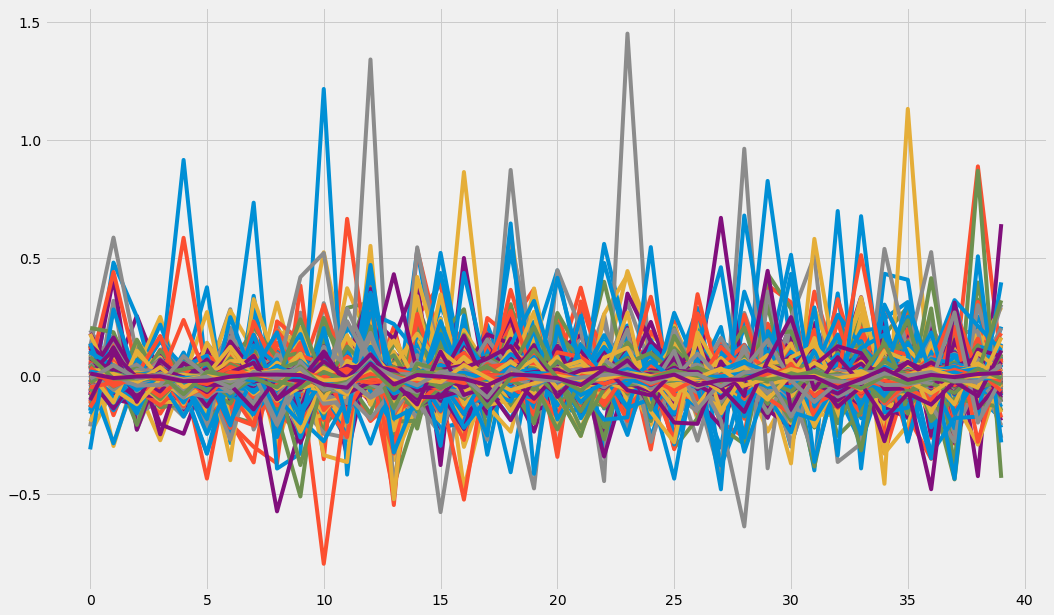

In [120]:
import matplotlib.pyplot as plt
a = clusters_data_list2[5]
for c in a['SecurityID']:
    try:
        grpah = new_data[new_data['SecurityID']==c].GSpread.pct_change().dropna().values
        coeffs = pywt.wavedec(grpah, 'db1', level=0)
        plt.plot(coeffs[0])
    except:
        pass
plt.rcParams["figure.figsize"] = (16,10)
plt.show()

In [121]:
for i in clusters_data_list2:
    print(len(i))

557
4270
993
1036
4281
1044
633
406


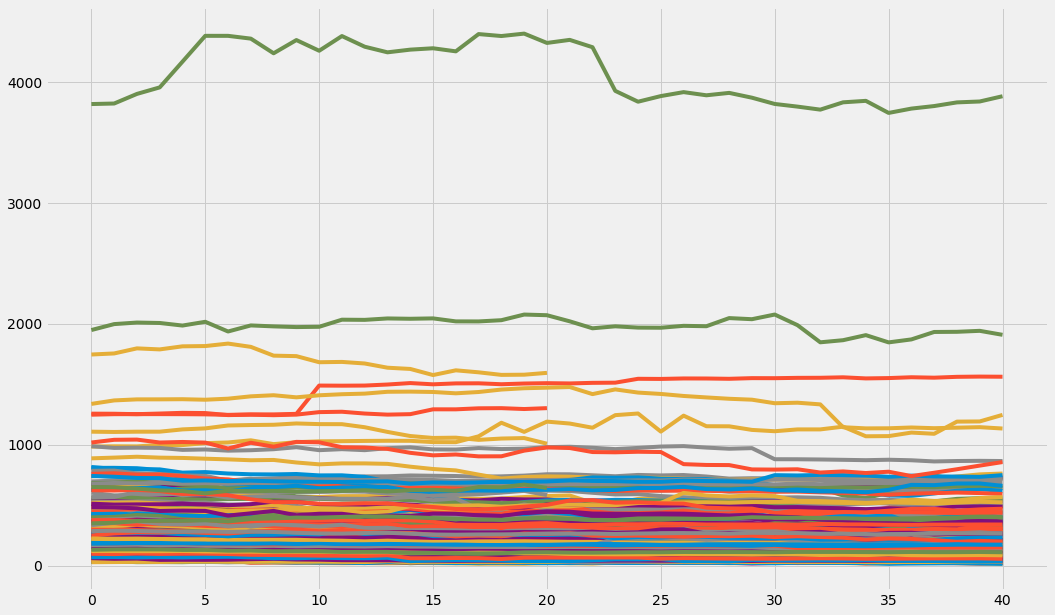

406

In [122]:
a = clusters_data_list2[7]
for c in a['SecurityID']:
    try:
        grpah = new_data[new_data['SecurityID']==c].GSpread.values
        plt.plot(grpah)
    except:
        pass
plt.show()
len(a)

In [123]:
data = {}
l = []
a = clusters_data_list2[0]
for c in a['SecurityID']:
    graph = new_data[new_data['SecurityID']==c].GSpread.pct_change().dropna().values
    if len(graph) == 40:
        data[c] = graph
        l.append(c)

In [124]:
df = pd.DataFrame(data,columns=l)

corrMatrix = df.corr()
print (corrMatrix)

183       1851      2855      2864      2876      2879      3207   \
183    1.000000  0.432510  0.160156  0.012083 -0.038361  0.260653 -0.220792   
1851   0.432510  1.000000  0.279326  0.302147  0.200717  0.378609  0.167243   
2855   0.160156  0.279326  1.000000  0.313544  0.028558  0.321524  0.078159   
2864   0.012083  0.302147  0.313544  1.000000  0.001242  0.308466  0.060161   
2876  -0.038361  0.200717  0.028558  0.001242  1.000000 -0.060031  0.007712   
...         ...       ...       ...       ...       ...       ...       ...   
53362  0.350159  0.439171  0.165970 -0.086994  0.028660  0.226649 -0.142921   
53561  0.326081  0.463559  0.090439  0.105287  0.177462  0.321952  0.138676   
53585  0.162594  0.151310  0.153520  0.327931  0.024696  0.086899  0.033949   
53602  0.203746  0.131293  0.018006  0.447092  0.140892  0.243661 -0.256219   
53632  0.295150  0.063147  0.316794  0.078320 -0.006919  0.217870 -0.056923   

          3281      3318      3321   ...     51905     52609 

In [125]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=110, random_state=42).fit(data_scaled)

In [126]:
kmeans.labels_

array([ 74, 102,  17, ...,  16,  61,  90], dtype=int32)

In [127]:
clusters3 = create_cluster_list(kmeans.labels_)
clusters_list3 = grab_clusters(clusters3,bond_spread_list,security_data,rating_data)

In [128]:
clusters_data_list3 = transfer_to_list_of_pd(clusters_list3)

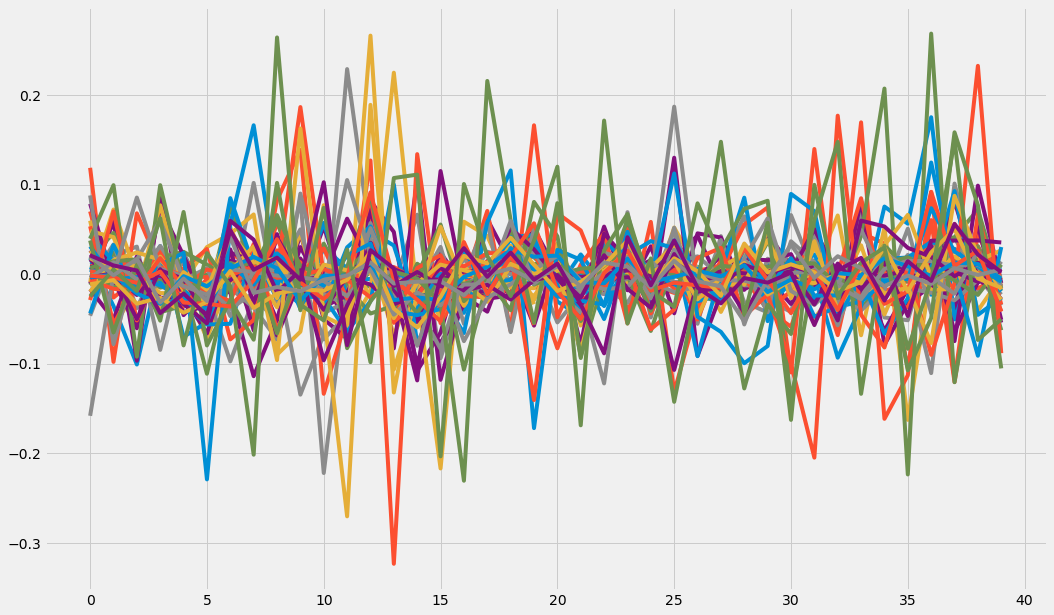

54

In [135]:
import pywt
a = clusters_data_list3[4]
for c in a['SecurityID']:
    try:
        graph = new_data[new_data['SecurityID']==c].GSpread.pct_change().dropna().values
        coeffs = pywt.wavedec(graph, 'db1', level=0)
        plt.plot(coeffs[0])
    except:
        pass
plt.rcParams["figure.figsize"] = (16,10)
plt.show()
len(a)

from sklearn.metrics import silhouette_score
inertias = {}
silhouettes = {}
for k in range(100, 150):
    kmeans = KMeans(init='k-means++', n_init=10, n_clusters=k, max_iter=1000, random_state=42).fit(data_scaled)
    inertias[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    silhouettes[k] = silhouette_score(data_scaled, kmeans.labels_, metric='euclidean')
    

plt.figure();
plt.grid(True);
plt.plot(list(inertias.keys()), list(inertias.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Inertia");


plt.figure();
plt.grid(True);
plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Silhouette");

In [130]:
for i in clusters_data_list3:
    print(len(i))

218
275
33
198
54
24
102
87
75
26
16
201
304
161
70
159
80
188
56
128
22
411
41
215
281
64
5
98
88
74
158
368
174
60
48
374
73
27
12
11
160
180
12
191
34
198
96
127
360
146
164
14
86
204
125
30
25
111
103
278
203
86
53
109
35
392
32
32
55
159
309
157
213
35
254
101
109
94
149
30
78
112
132
128
180
3
191
55
38
8
89
141
23
166
23
3
23
203
53
19
178
1
259
120
64
63
58
54
210
235


In [131]:
len(clusters_data_list3)

110